In [0]:
#@title ~ import packages
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [50]:
# download image
! wget 'https://storage.googleapis.com/meso_patho/P_blood_20130703.jpg'

--2020-05-19 11:26:16--  https://storage.googleapis.com/meso_patho/P_blood_20130703.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 2607:f8b0:400c:c1a::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182614 (178K) [image/jpeg]
Saving to: ‘P_blood_20130703.jpg.1’

P_blood_20130703.jp 100%[===================>] 178.33K  --.-KB/s    in 0.002s  

2020-05-19 11:26:16 (110 MB/s) - ‘P_blood_20130703.jpg.1’ saved [182614/182614]



image array shape = (960, 1280, 3)


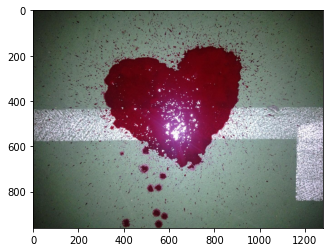

In [51]:
#@title 0 read image data
image = Image.open('P_blood_20130703.jpg')
img = np.array(image)  # convert to ndarray
print("image array shape =", img.shape)

# plot image
plt.imshow(img)
plt.show()

# 1 影像處理

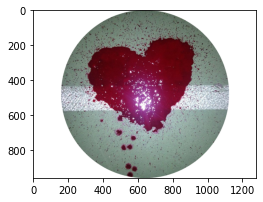

In [52]:
#@title set ROI
#@markdown https://scikit-image.org/docs/stable/auto_examples/numpy_operations/plot_camera_numpy.html#sphx-glr-auto-examples-numpy-operations-plot-camera-numpy-py

camera = img.copy()  # 複製一份影像作處理

l_x, l_y = camera.shape[0], camera.shape[1]
X, Y = np.ogrid[:l_x, :l_y]
outer_disk_mask = (X - l_x / 2)**2 + (Y - l_y / 2)**2 > (l_x / 2)**2
camera[outer_disk_mask] = 255  # 填上白色

plt.figure(figsize=(4, 4))
plt.imshow(camera, cmap='gray')
# plt.axis('off')
plt.show()

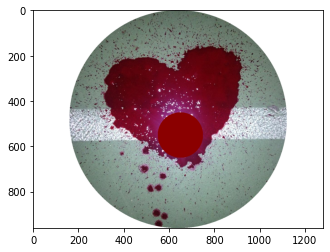

In [53]:
#@title draw circle
#@markdown https://scikit-image.org/docs/stable/api/skimage.draw.html?highlight=draw#module-skimage.draw

x = 650 #@param
y = 550 #@param
r = 100 #@param

from skimage.draw import circle

# fill circle
filled_circle = camera.copy()  # 複製一份
rr, cc = circle(y, x, r)
filled_circle[rr, cc, :] = (139, 0, 0)  # fill color darkred

# plot
plt.imshow(filled_circle)
# plt.axis('off')
plt.show()

# 2 二值化影像

thresh_min = 65


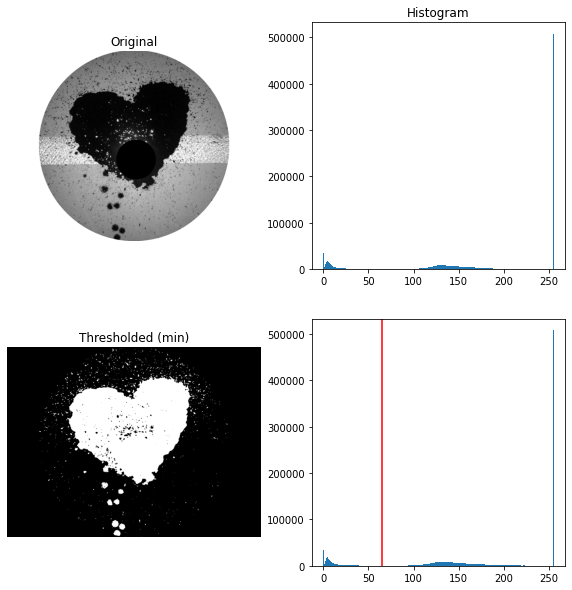

In [54]:
#@title Thresholding
#@markdown https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html#sphx-glr-auto-examples-applications-plot-thresholding-py

threshold =  75#@param

from skimage.filters import threshold_minimum

image = filled_circle.copy()[:,:,1]  # get G-channel

thresh_min = threshold_minimum(image)
print("thresh_min =", thresh_min)
binary_mask = image < threshold

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_mask, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

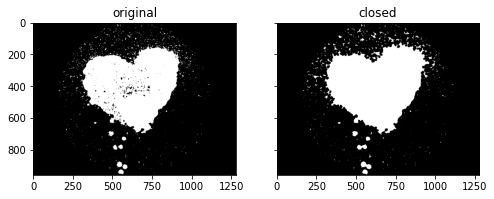

In [55]:
#@title Morphological Filtering
#@markdown https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html#sphx-glr-auto-examples-applications-plot-morphology-py

from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
selem = disk(6)  # filter 的大小

image = binary_mask.copy()  # 複製一份
filted = closing(image, selem)  # 封閉

# plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                sharey=True)
ax1.imshow(binary_mask, cmap=plt.cm.gray)
ax1.set_title('original')
# ax1.axis('off')
ax2.imshow(filted, cmap=plt.cm.gray)
ax2.set_title('closed')
# ax2.axis('off')
plt.show()

# 3 計算血量

total_blood pixels = 249570
one_drop pixels = 860


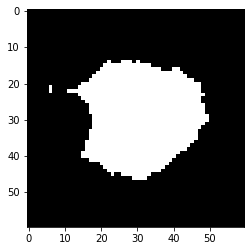

In [56]:
#@title count total blood pixel

total_blood = filted.sum()
print("total_blood pixels =", total_blood)

# sigle drop
drop = filted[670:730, 460:520]
print("one_drop pixels =", drop.sum())

plt.imshow(drop, cmap=plt.cm.gray)
plt.show()

two_drops pixels = 1379


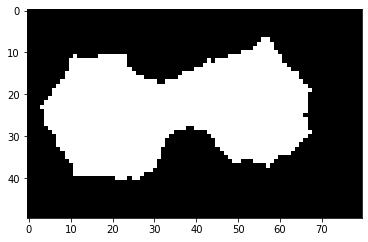

In [57]:
twodrops = filted[760:810, 500:580]
print("two_drops pixels =", twodrops.sum())
plt.imshow(twodrops, cmap=plt.cm.gray)
plt.show()

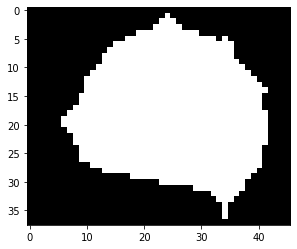

In [72]:
drop2 = filted[922:980, 530:576]
plt.imshow(drop2, cmap=plt.cm.gray)
plt.show()

In [75]:
drop_p = (drop.sum() + twodrops.sum() + drop2.sum())/4
print('average pixel per drop: ' + str(drop_p))

average pixel per drop: 757.25


total blood valume ~ 16.479 mL


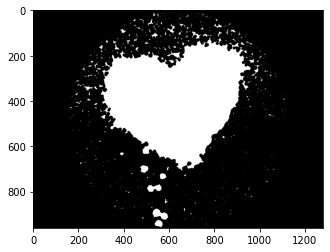

In [76]:
#@title culculate blood valume

volume = total_blood.sum() / drop_p.sum() * 0.05
print("total blood valume ~ {:.3f} mL".format(volume))

plt.imshow(filted, cmap=plt.cm.gray)
plt.show()

# 嘗試其他的影像處理方式

In [0]:
#@title Niblack and Sauvola Thresholding
#@markdown https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_niblack_sauvola.html#sphx-glr-auto-examples-segmentation-plot-niblack-sauvola-py

from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

image = img.copy()[:,:,1]  # get G-channel
binary_global = image > threshold_otsu(image)

window_size = 25
thresh_niblack = threshold_niblack(image, window_size=window_size, k=0.8)
thresh_sauvola = threshold_sauvola(image, window_size=window_size)

binary_niblack = image > thresh_niblack
binary_sauvola = image > thresh_sauvola

plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Global Threshold')
plt.imshow(binary_global, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(binary_niblack, cmap=plt.cm.gray)
plt.title('Niblack Threshold')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(binary_sauvola, cmap=plt.cm.gray)
plt.title('Sauvola Threshold')
plt.axis('off')

plt.show()